In [ ]:

import torch
import torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from snntorch import surrogate
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
num_steps = 25
num_inputs = 28 * 28
num_hidden = 100
num_outputs = 10
learning_rate = 1e-3
lambda_sparsity = 0.1
num_epochs = 10

# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)


In [3]:
# SNN with DSC
class SNNWithDSC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        # Enhanced threshold networks with conservative initialization
        self.threshold_net1 = nn.Sequential(
            nn.Linear(num_inputs, 50),
            nn.ReLU(),
            nn.Linear(50, num_hidden),
            nn.Sigmoid()
        )
        self.threshold_net2 = nn.Sequential(
            nn.Linear(num_hidden, 50),
            nn.ReLU(),
            nn.Linear(50, num_outputs),
            nn.Sigmoid()
        )
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        # Initialize with lower weights
        self.threshold_net1.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        self.threshold_net2.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        for net in [self.threshold_net1, self.threshold_net2]:
            for layer in net:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            scale1 = 1.0 - self.threshold_net1(x[step])
            cur1 = self.fc1(x[step]) * scale1.clamp(min=0.1)
            spk1, mem1 = self.lif1(cur1, mem1)
            scale2 = 1.0 - self.threshold_net2(spk1)
            cur2 = self.fc2(spk1) * scale2.clamp(min=0.1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

In [4]:
# Instantiate network and optimizer
net = SNNWithDSC().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

In [5]:
# Training and evaluation
accuracies, val_accuracies, spike_rates, losses = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        data = data.view(batch_size_actual, -1)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        spike_rate = (spk1_rec.mean() + outputs.mean()) / 2
        total_loss = loss + lambda_sparsity * spike_rate
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)
        optimizer.step()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
    scheduler.step(loss.item())
    losses.append(loss.item())
    spike_rates.append(spike_rate.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            data = data.view(batch_size_actual, -1)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Spike Rate: {spike_rate.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {total_spikes}")


Epoch 1, Loss: 0.1187, Spike Rate: 0.1104, Accuracy: 0.9688, Validation Accuracy: 0.9371, Total Spikes: 3636260.0
Epoch 2, Loss: 0.1847, Spike Rate: 0.1027, Accuracy: 0.9375, Validation Accuracy: 0.9533, Total Spikes: 2905069.0
Epoch 3, Loss: 0.0184, Spike Rate: 0.0918, Accuracy: 1.0000, Validation Accuracy: 0.9591, Total Spikes: 2632221.0
Epoch 4, Loss: 0.0340, Spike Rate: 0.0853, Accuracy: 1.0000, Validation Accuracy: 0.9648, Total Spikes: 2308349.0
Epoch 5, Loss: 0.1354, Spike Rate: 0.0846, Accuracy: 0.9688, Validation Accuracy: 0.9675, Total Spikes: 2276219.0
Epoch 6, Loss: 0.0061, Spike Rate: 0.0818, Accuracy: 1.0000, Validation Accuracy: 0.9687, Total Spikes: 2118423.0
Epoch 7, Loss: 0.1656, Spike Rate: 0.0882, Accuracy: 0.9688, Validation Accuracy: 0.9709, Total Spikes: 2182372.0
Epoch 8, Loss: 0.0654, Spike Rate: 0.0852, Accuracy: 1.0000, Validation Accuracy: 0.9689, Total Spikes: 1958959.0
Epoch 9, Loss: 0.1642, Spike Rate: 0.0774, Accuracy: 0.9688, Validation Accuracy: 0.9710

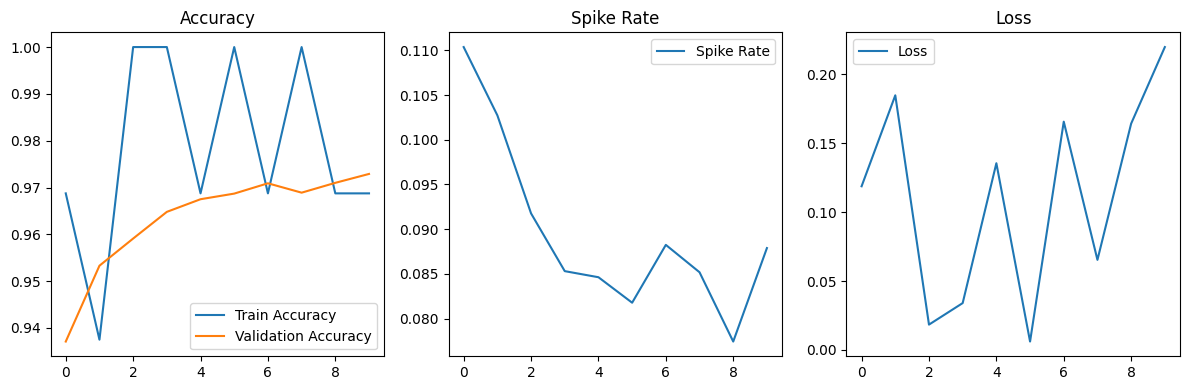

In [7]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(spike_rates, label="Spike Rate")
plt.title("Spike Rate")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("dsc_results.png")
plt.show()